In [19]:
import sys
sys.path.append("../python/")
sys.path.append("../python/cluster")

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.lines import Line2D
import bokeh.palettes
import _corner
import imp
imp.reload(_corner)
from _corner import corner
from scipy.stats import gaussian_kde
import pickle
from matplotlib.offsetbox import AnchoredText
import mock_generation
imp.reload(mock_generation)
from mock_generation import mock_population
from astropy.constants import R_jup, M_jup, M_sun, L_sun
from scipy.interpolate import interp1d, interp2d
from utils import temperature, heat, temperature_withDM
from scipy.stats import loguniform

import sensitivity
imp.reload(sensitivity)
from sensitivity import sensitivity

from matplotlib import rc
rc('font', family='times new roman', size=22.)

In [9]:
# TODO update for g <=0
def random_powerlaw(a, b, g, size=1):
    """
    Power-law generator for pdf(x) = x^{g-1} for a<=x<=b and g<0
    """
    r = np.random.random(size=size)
    ag, bg = a**g, b**g
    return (ag + (bg - ag)*r)**(1./g)

In [10]:
np.random.seed(42)
# Number of simulated exoplanets
N = 10000

# galactocentric radius of simulated exoplanets
r_obs = loguniform.rvs(0.1, 8.178, size=N)

## load theoretical BD cooling model taken from Saumon & Marley '08 (fig 2)
age  = {}; logL = {}; L = {}; Teff = {}
M    = [0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08]

# TODO simplify by directly interpolating on heating/luminosity
for mass in M:
    data = np.genfromtxt("../data/evolution_models/SM08/saumon_marley_fig2_" + str(mass) + ".dat", 
                         unpack=True)
    age[mass]  = data[0]
    heat_int   = np.power(10, data[1])*L_sun.value
    Teff[mass] = temperature(heat_int, R_jup)
log_age  = np.linspace(6.1, 9.92, 10)
_log_age = []
_mass    = []
_teff    = []
for m in M:
    Teff_interp = interp1d(age[m], Teff[m])
    for lage in log_age:
        _log_age.append(lage)
        _mass.append(m)
        _teff.append(Teff_interp(lage))
# effective temperature (wo DM heating) vs log(age) and mass exoplanet
Teff_interp_2d = interp2d(_log_age, _mass, _teff)
del age, logL, L, M, Teff, _log_age, _mass, _teff

## Ages and masses of simulated BDs
log_ages = np.random.uniform(9., 9.92, N) # [yr] / [1-10 Gyr]
mass     = random_powerlaw(14, 75, -0.01, N)
#fig, ax = plt.subplots(1, 1, figsize=(5, 5))
#_, _, _ = ax.hist(mass, bins=40)
mass     = mass*M_jup/M_sun # [Msun]
# Mapping (mass, age) -> Teff -> internal heat flow (no DM)
heat_int = np.zeros(N)
Teff     = np.zeros(N)
for i in range(N):
    Teff[i]     = Teff_interp_2d(log_ages[i], mass[i])
    heat_int[i] = heat(Teff[i], R_jup.value)

In [11]:
rel_unc=0.05
Teff_obs = Teff + np.random.normal(loc=0, scale=(rel_unc*Teff), size=N)

In [20]:
sensitivity(r_obs, Teff_obs, Teff)

1.0


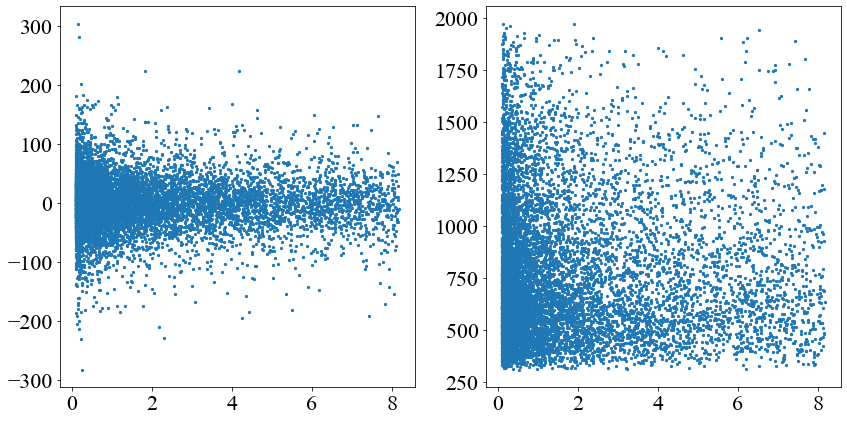

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7))

ax[0].scatter(r_obs, Teff_obs-Teff, s=5)

ax[1].scatter(r_obs, Teff, s=5)

In [17]:
Tobs = temperature_withDM(r_obs, heat_int, f=1, R=R_jup.value, 
                          M=mass*M_sun.value, parameters=[1, 20, 0.42])

Tobs_obs = Tobs + np.random.normal(loc=0, scale=(rel_unc*Tobs), size=N)

In [26]:
sensitivity(r_obs, Tobs_obs, Teff, Nbins=2, r_max=1)

0.5662305640510075


In [50]:
r_bins = np.logspace(np.log10(0.1), np.log10(8.178), 10)
mean_eff = []; mean_obs = []
std_eff = []; std_obs = []
_r = []

res_eff = Teff_obs - Teff
res_obs = Tobs_obs - Teff

for i in range(len(r_bins)-1):
    pos = np.where((r_obs > r_bins[i]) & (r_obs < r_bins[i+1]))
    #print(len(r_obs[pos]))
    mean_eff.append(np.mean(res_eff[pos])); std_eff.append(np.std(res_eff[pos]))
    mean_obs.append(np.mean(res_obs[pos])); std_obs.append(np.std(res_obs[pos]))
    _r.append(0.5*(r_bins[i] + r_bins[i+1]))

std_eff = np.array(std_eff)
std_obs = np.array(std_obs)

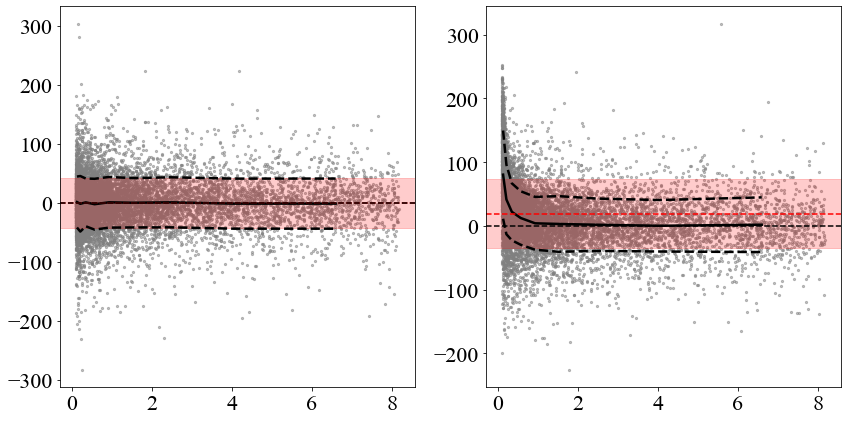

In [57]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7))


ax[0].scatter(r_obs, Teff_obs-Teff, s=5, color="grey", alpha=0.5)
ax[0].plot(_r, mean_eff, color="k", lw=2.5)
ax[0].plot(_r, mean_eff + std_eff, color="k", lw=2.5, ls="--")
ax[0].plot(_r, mean_eff-std_eff, color="k", lw=2.5, ls="--")
ax[0].axhline(np.mean(res_eff), ls="--", color="r")
ax[0].axhspan(np.mean(res_eff)-np.std(res_eff), np.mean(res_eff)+np.std(res_eff), color="r", alpha=0.2)
ax[0].axhline(0, ls="--", color="k")

ax[1].scatter(r_obs, Tobs_obs-Teff, s=5, color="grey", alpha=0.5)
ax[1].plot(_r, mean_obs, color="k", lw=2.5)
ax[1].plot(_r, mean_obs+std_obs, color="k", lw=2.5, ls="--")
ax[1].plot(_r, mean_obs-std_obs, color="k", lw=2.5, ls="--")
ax[1].axhline(np.mean(res_obs), ls="--", color="r")
ax[1].axhspan(np.mean(res_obs)-np.std(res_obs), np.mean(res_obs)+np.std(res_obs), color="r", alpha=0.2)
ax[1].axhline(0, ls="--", color="k")

In [36]:
def random_powerlaw(alpha, size, Mmin=14, Mmax=55):
    """
    Power-law generator
    """
    y = np.random.uniform(0, 1, size=size)
    return ((Mmax**(alpha+1) - Mmin**(alpha+1))*y + Mmin**(alpha+1))**(1./(alpha+1))

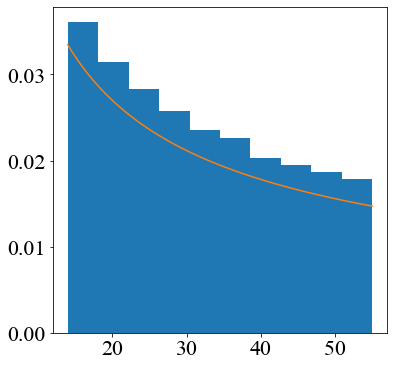

In [47]:
mass = random_powerlaw(-0.6, 100000)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
_, _, _ = ax.hist(mass, density=True)
mass = np.linspace(14, 55, 100)
ax.plot(mass, 0.1629*mass**-0.6)